In [6]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# setup parsl

This code sets parsl resources

In [7]:
import IMLCV

from IMLCV.configs.config_general import config
config(    local_ref_threads  = 2, initialize_logging = False)

parsl already configured, using previous setup


# make MD simulations for alanine dipeptide in 2 stable minima

In [8]:
from IMLCV.examples.example_systems import alanine_dipeptide_refs
from IMLCV.examples.example_systems import alanine_dipeptide_yaff
from IMLCV.implementations.CV import NoneCV
from IMLCV.base.rounds import Rounds
from IMLCV.base.bias import NoneBias


from pathlib import Path

folder = Path("alanine_dipeptide_LDA")

if not folder.exists():

    lda_steps = 1e4

    mde = alanine_dipeptide_yaff()
    refs = alanine_dipeptide_refs()

    rnds = Rounds(folder=folder)
    rnds.add_cv_from_cv(cv=NoneCV())
    rnds.add_round_from_md(mde)

    biases = []
    for _ in refs:
        biases.append(NoneBias(cvs=NoneCV()))

    rnds.run_par(biases=biases, steps=lda_steps, sp0=refs, plot=False)
else:
    rnds = Rounds(folder=folder, new_folder=False)


# discover new CV with LDA between phases

In [9]:
from IMLCV.scheme import Scheme
scheme0 = Scheme.from_rounds(rnds)

Loading MD engine
setting filename=None


In [5]:


from IMLCV.base.CVDiscovery import CVDiscovery
from IMLCV.implementations.CvDiscovery import TransoformerLDA
from IMLCV.implementations.CV import sb_descriptor

from molmod.units import angstrom


out_dim = 1
r_cut = 4.0 * angstrom


descriptor = sb_descriptor(r_cut=r_cut, n_max=2, l_max=2, reshape=True)
tf = TransoformerLDA(outdim=out_dim, descriptor=descriptor)

scheme0.update_CV(
    samples=1e3,
    split_data=True,
    cvd=CVDiscovery(transformer=tf),
    new_r_cut=r_cut,
    chunk_size=300,
    alpha_rematch=0.05,
    plot=True,
    pre_scale=False,
    sort="rematch",
)


AssertionError: 

# do new MD run with discovered CV

In [ ]:
from molmod.units import kjmol

scheme0.inner_loop( rnds=3, n=4,steps=1000, init=500, plot=True)

running init round with 500 steps
Loading MD engine
new point got cv=None, e_pot=None and new bias 0.393479598811746 
new point got cv=None, e_pot=None and new bias 12.847324078308539 
new point got cv=None, e_pot=None and new bias 60.77624903349331 
new point got cv=None, e_pot=None and new bias 144.18025446436613 
running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.92160289]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-7.58302972] and new bias 0.24528784312973964 
new point got cv=CV(cv=array([[-0.90425351]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[0.73203679] and new bias 13.008484104237455 
new point got cv=CV(cv=array([[-0.77797389]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-4.64310037] and new bias 49.288339804550255 
new point got cv=CV(cv=array([[-0.63059114]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[40.88069526]

lets look at the umbrella simulations and the produced Free energy surface

In [6]:
from IPython.display import IFrame
from IPython.display import Image,display
from pdf2image import convert_from_path

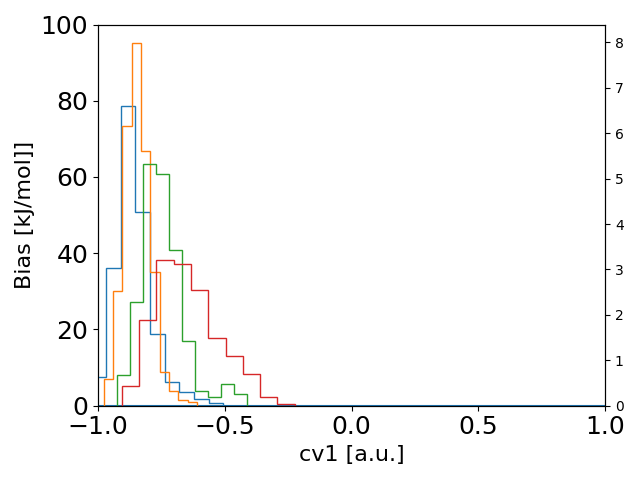

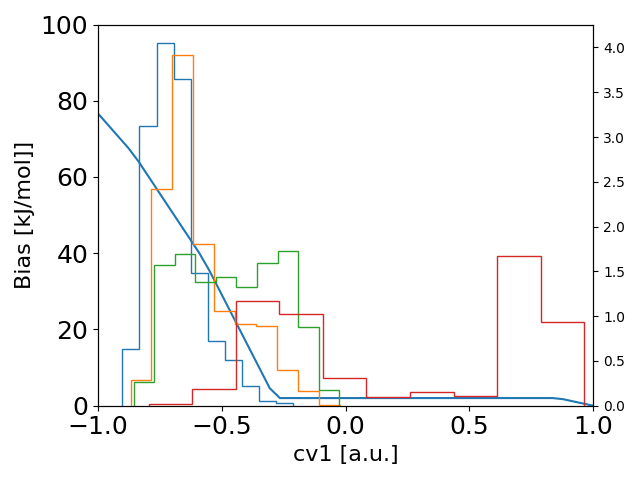

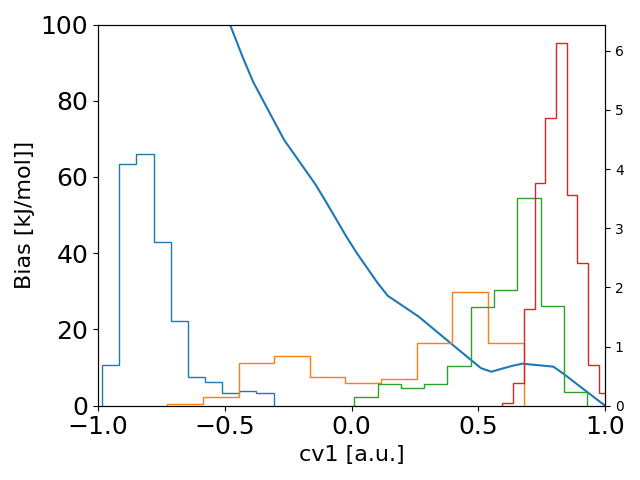

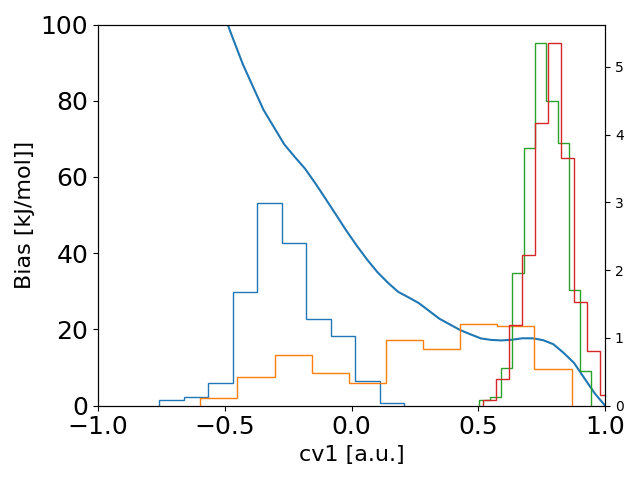

In [18]:
display(  *[Image(   folder/"cv_1"/f"round_{i}"/"combined.png" , width=500  ) for i in range(1,5)]   )


Clearly, the umbrellas stay in the same phase (because they were all started from the same seed). The generated free energy surface tries to compensate:



In [32]:
scheme0.inner_loop( rnds=3, n=4,steps=1000, init=0, plot=True)

running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.5733971]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[98.63807068] and new bias 7.263125068787482 
new point got cv=CV(cv=array([[-0.43159576]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[45.12364562] and new bias 0.38534605907860914 
new point got cv=CV(cv=array([[0.55898699]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[15.26303079] and new bias 2.0321729351181816 
new point got cv=CV(cv=array([[0.571631]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[1.88967389] and new bias 7.32338697041011 
Loading MD engine
setting bias=<IMLCV.implementations.bias.GridBias object at 0x7f8185e0ba60>
running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.21756819]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[78.4759501] and new bias 24.4

let's look at the coverage and convergence

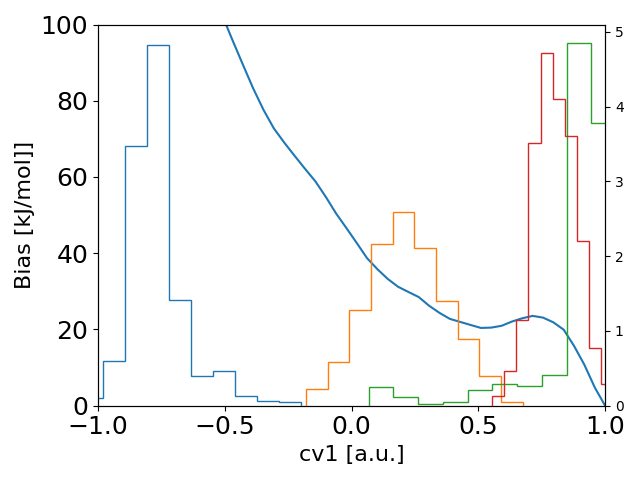

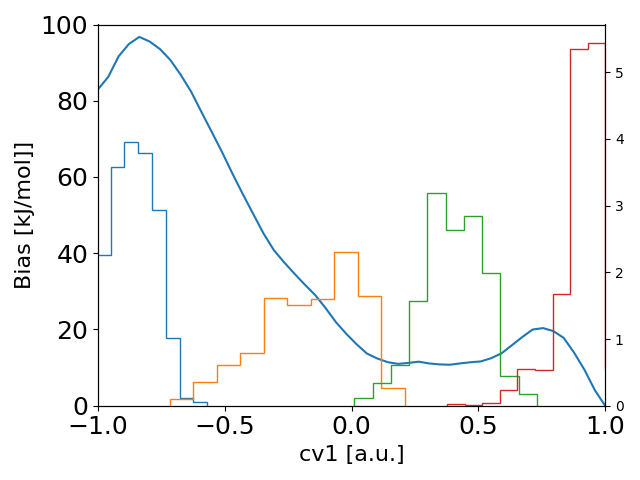

In [29]:
display(  *[Image(   folder/"cv_1"/f"round_{i}"/"combined.png" , width=500  ) for i in range(5,7)]   )

The umbrellas mmore or less cover the CV range, let's check if the FES has converged

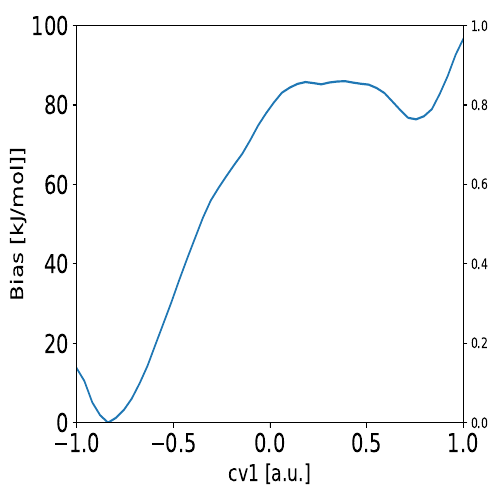

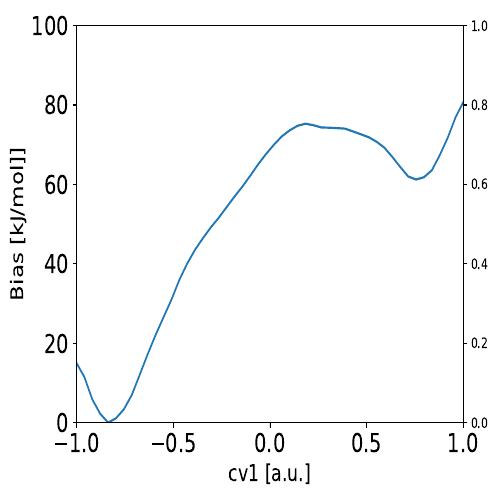

In [30]:


display(  *[ convert_from_path(folder/"cv_1"/f"FES_bias_{i}_inverted_gridbias.pdf"  , size=(500,500) , dpi=200  )[0]  for i in range(5,7) ]   )


The FES has not converged yet, so more samping is needed

In [58]:
scheme0.inner_loop( rnds=3, n=4,steps=1000, init=0, plot=True)

running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.66854722]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[7.28265989] and new bias 4.384491684502823 
new point got cv=CV(cv=array([[-0.67800279]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[49.24556706] and new bias 4.741126205845682 
new point got cv=CV(cv=array([[0.17493316]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[28.17761697] and new bias 1.0013530041190866 
new point got cv=CV(cv=array([[0.92866266]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[16.09948965] and new bias 0.20309992158075915 
Loading MD engine
setting bias=<IMLCV.implementations.bias.GridBias object at 0x7f80cee2a680>
running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.82043008]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-12.34847118] and new bia

Now we'll compare the FES again for round 8 and 9

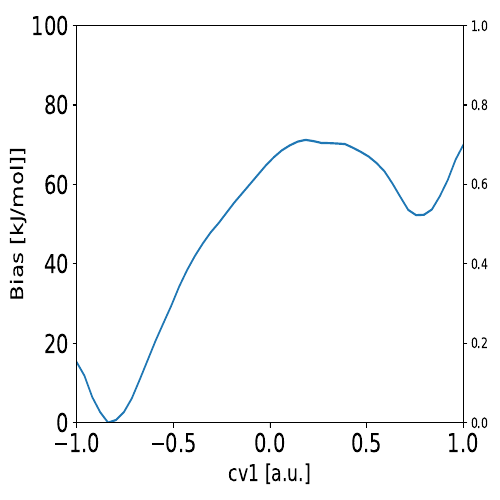

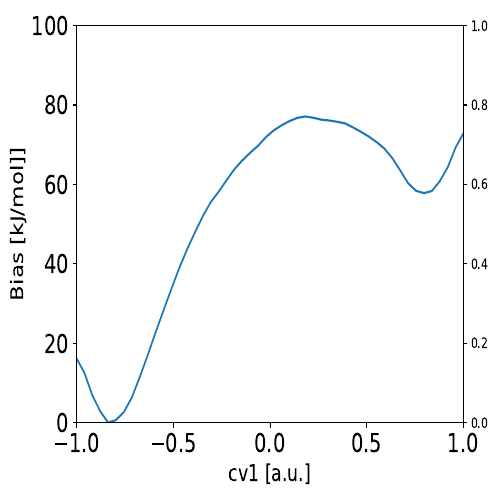

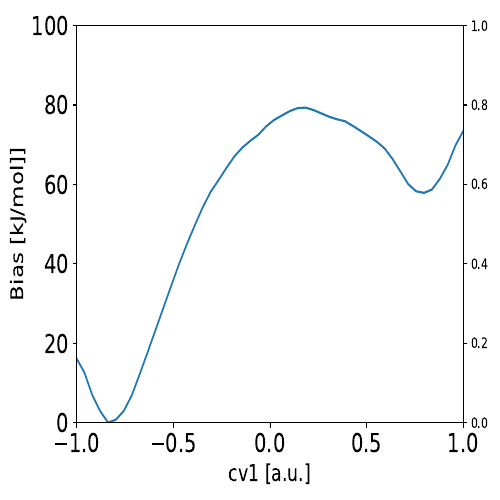

In [31]:

display(  *[ convert_from_path(folder/"cv_1"/f"FES_bias_{i}_inverted_gridbias.pdf"  , size=(500,500) , dpi=200  )[0]  for i in range(7,10) ]   )

# look for new CV wiht UMAP

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


starting pre_fit


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


starting fit


/home/david/Documents/Projects/IMLCV/.micromamba/envs/default/lib/python3.10/site-packages/umap/parametric_umap.py:375: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


272/451 [=================>............] - ETA: 2s - loss: 0.3780 - reconstruction_loss: 0.0935 - umap_loss: 0.2846

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 9s 15ms/step - loss: 0.3415 - reconstruction_loss: 0.0809 - umap_loss: 0.2606
Epoch 2/10
159/451 [=========>....................] - ETA: 4s - loss: 0.2762 - reconstruction_loss: 0.0586 - umap_loss: 0.2177

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2733 - reconstruction_loss: 0.0572 - umap_loss: 0.2161
Epoch 3/10
 51/451 [==>...........................] - ETA: 6s - loss: 0.2695 - reconstruction_loss: 0.0554 - umap_loss: 0.2141

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


395/451 [=========================>....] - ETA: 0s - loss: 0.2683 - reconstruction_loss: 0.0545 - umap_loss: 0.2138

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2679 - reconstruction_loss: 0.0544 - umap_loss: 0.2136
Epoch 4/10
283/451 [=================>............] - ETA: 2s - loss: 0.2639 - reconstruction_loss: 0.0527 - umap_loss: 0.2112

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 14ms/step - loss: 0.2640 - reconstruction_loss: 0.0524 - umap_loss: 0.2116
Epoch 5/10
179/451 [==========>...................] - ETA: 3s - loss: 0.2628 - reconstruction_loss: 0.0511 - umap_loss: 0.2118

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2620 - reconstruction_loss: 0.0506 - umap_loss: 0.2113
Epoch 6/10
 65/451 [===>..........................] - ETA: 5s - loss: 0.2603 - reconstruction_loss: 0.0496 - umap_loss: 0.2107

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


414/451 [==========================>...] - ETA: 0s - loss: 0.2597 - reconstruction_loss: 0.0491 - umap_loss: 0.2106

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2596 - reconstruction_loss: 0.0491 - umap_loss: 0.2105
Epoch 7/10
313/451 [===================>..........] - ETA: 1s - loss: 0.2578 - reconstruction_loss: 0.0482 - umap_loss: 0.2096

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2578 - reconstruction_loss: 0.0481 - umap_loss: 0.2097
Epoch 8/10
209/451 [============>.................] - ETA: 3s - loss: 0.2565 - reconstruction_loss: 0.0474 - umap_loss: 0.2091

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2565 - reconstruction_loss: 0.0472 - umap_loss: 0.2093
Epoch 9/10
102/451 [=====>........................] - ETA: 5s - loss: 0.2551 - reconstruction_loss: 0.0468 - umap_loss: 0.2083

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


448/451 [============================>.] - ETA: 0s - loss: 0.2556 - reconstruction_loss: 0.0466 - umap_loss: 0.2090

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2556 - reconstruction_loss: 0.0466 - umap_loss: 0.2090
Epoch 10/10
345/451 [=====================>........] - ETA: 1s - loss: 0.2550 - reconstruction_loss: 0.0462 - umap_loss: 0.2088

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2548 - reconstruction_loss: 0.0462 - umap_loss: 0.2086


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


starting post_fit


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strateg

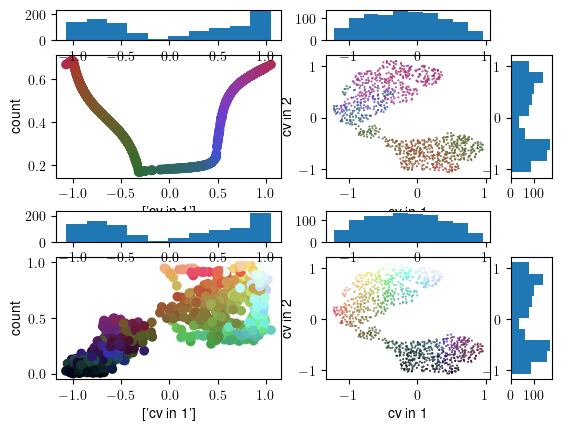

In [7]:
from IMLCV.base.CVDiscovery import CVDiscovery
from IMLCV.implementations.tensorflow.CvDiscovery import TranformerUMAP
from IMLCV.implementations.CV import sb_descriptor
from tensorflow import keras

from molmod.units import angstrom
   


out_dim = 2
r_cut = 4.0 * angstrom


descriptor = sb_descriptor(r_cut=r_cut, n_max=2, l_max=2, reshape=True)


tf = TranformerUMAP(outdim=out_dim, descriptor=descriptor)


cvd = CVDiscovery(
    transformer=tf,
)


scheme0.update_CV(
        samples=1e3,
        cvd=cvd,
        new_r_cut=r_cut,
        chunk_size=300,
        n_neighbors=40,
        min_dist=0.8,
        nunits=50,
        nlayers=2,
        metric="l2",
        densmap=False,
        parametric_reconstruction=True,
        parametric_reconstruction_loss_fcn=keras.losses.MSE,
        decoder=True,
    
)

# compare with backbone dihedral angles

For alanine dipeptide, the most well-known CVs are the so called backbone dihedral angles. We'll compare them here with our UMAP CVs

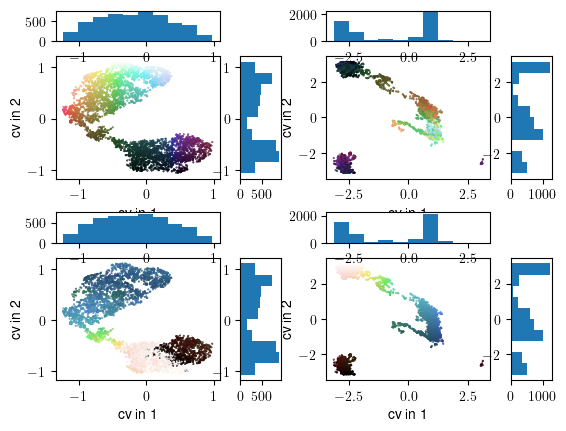

In [4]:
from IMLCV.base.CV import CollectiveVariable,CvMetric
from IMLCV.implementations.CV import dihedral
import numpy as np
from IMLCV.base.CVDiscovery import CVDiscovery

bd_cv0 = CollectiveVariable(
    f=(dihedral(numbers=[4, 6, 8, 14]) + dihedral(numbers=[6, 8, 14, 16])),
    metric=CvMetric(
        periodicities=[True, True],
        bounding_box=[[-np.pi, np.pi], [-np.pi, np.pi]],
    ),
)

umap_cv = scheme0.md.bias.collective_variable

sp,nl,cv,sti =  CVDiscovery.data_loader(  scheme0.rounds,out=5e3,new_r_cut= scheme0.md.static_trajectory_info.r_cut  ,cv_round=1      )


CVDiscovery.plot_app(  name= folder/"cv_2"/"comp_bd.pdf",  sps=  sp[0] ,   nl=  nl[0],   old_cv=umap_cv, new_cv=bd_cv0, chunk_size=300)

The clustering is clearly very similar, and the 2 main part are separated by a narrow passage. Both structures follow the same passage. It is clear that not the full sphase space hase been discovered yet, so we perform new umbralla sampling with the UMAP CV

In [16]:

scheme0.inner_loop( rnds=3, n=4,steps=1000, init=1000, plot=True)

running init round with 500 steps
Loading MD engine
new point got cv=None, e_pot=None and new bias 61.32710647583008 
new point got cv=None, e_pot=None and new bias 68.84111022949219 
new point got cv=None, e_pot=None and new bias 111.83019256591797 
new point got cv=None, e_pot=None and new bias 190.29434204101562 
new point got cv=None, e_pot=None and new bias 13.898341178894043 
new point got cv=None, e_pot=None and new bias 21.41234016418457 
new point got cv=None, e_pot=None and new bias 64.40142059326172 
new point got cv=None, e_pot=None and new bias 142.86558532714844 
new point got cv=None, e_pot=None and new bias 1.9446583986282349 
new point got cv=None, e_pot=None and new bias 9.458658218383789 
new point got cv=None, e_pot=None and new bias 52.44773864746094 
new point got cv=None, e_pot=None and new bias 130.91189575195312 
new point got cv=None, e_pot=None and new bias 25.466054916381836 
new point got cv=None, e_pot=None and new bias 32.98005294799805 
new point got cv=

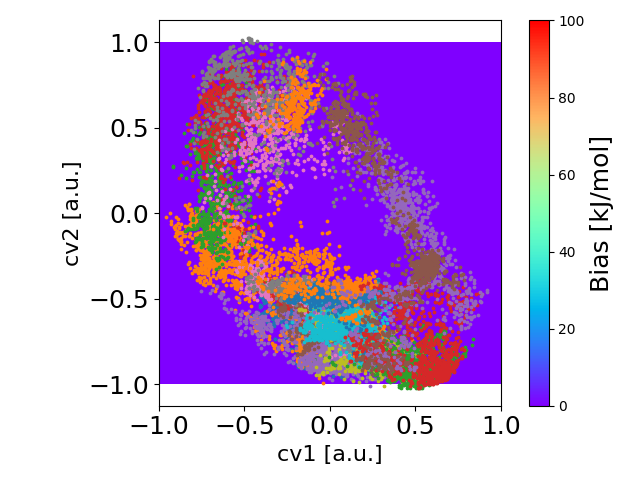

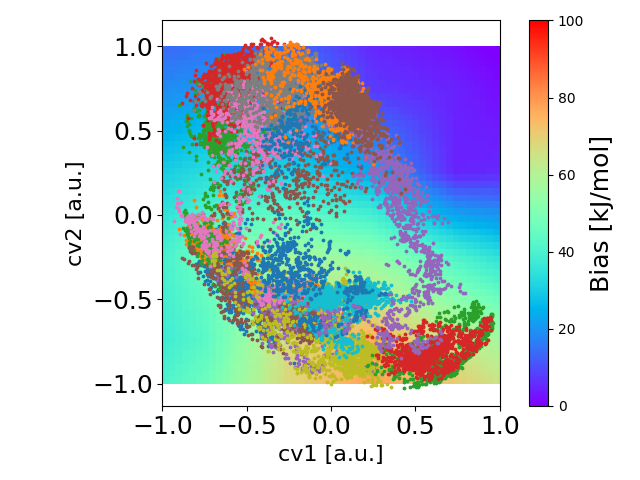

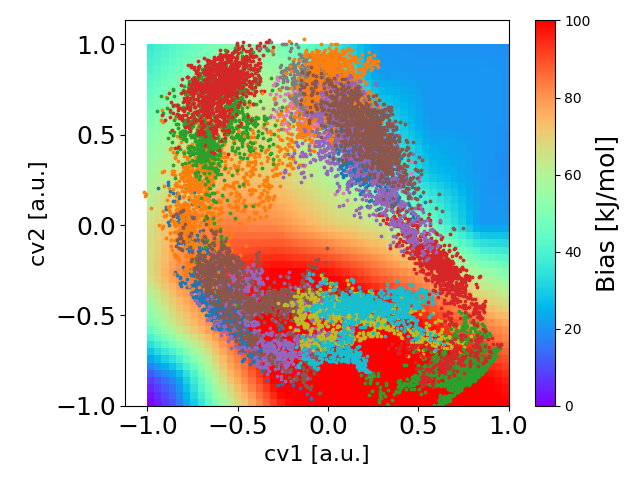

In [19]:
display(  *[Image(   folder/"cv_2"/f"round_{i}"/"combined.png" , width=500  ) for i in range(1,4)]   )

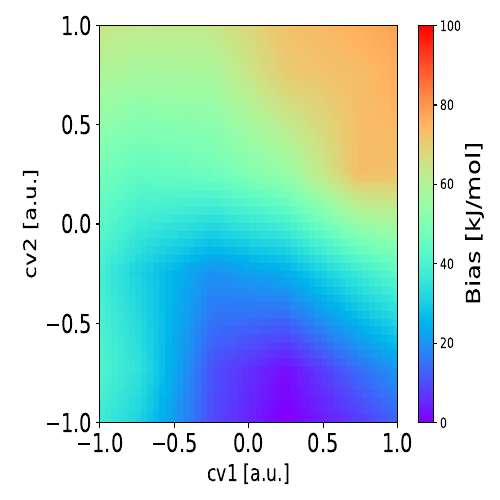

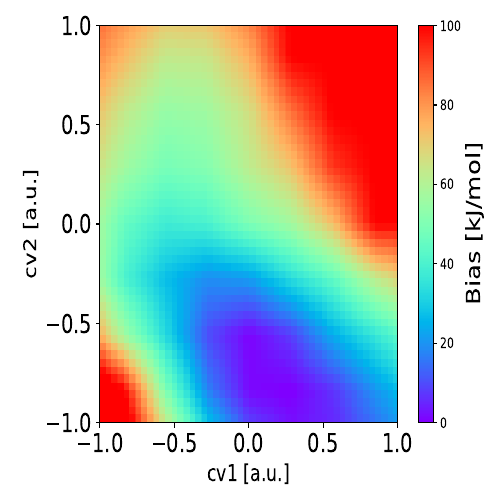

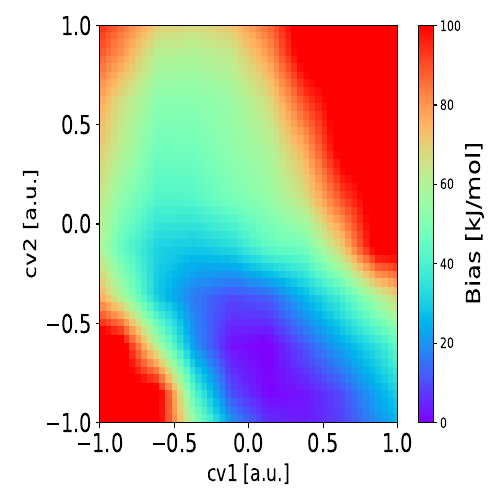

In [20]:

display(  *[ convert_from_path(folder/"cv_2"/f"FES_bias_{i}_inverted_gridbias.pdf"  ,  dpi=200  )[0]  for i in range(1,4) ]   )

the FES is not converged yet. There is not a lot of structure, try smaller grid

In [12]:
# scheme0.FESBias(samples_per_bin=300, num_rnds=4 ,choice="rbf",plot=True )
# scheme0.rounds.add_round_from_md(scheme0.md)

Loading MD engine
setting bias=<IMLCV.implementations.bias.RbfBias object at 0x7f2362d787f0>


In [6]:
scheme0.inner_loop( rnds=3, n=8,steps=1000, init=0, plot=True, choice="rbf",fes_bias_rnds=4 ,samples_per_bin=300)

running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.38576248, -0.87453681]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-2.77144726] and new bias 0.015317936427891254 
new point got cv=CV(cv=array([[-0.38837522, -0.86400783]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[23.69248678] and new bias 0.01545328926295042 
new point got cv=CV(cv=array([[-0.358592 , -0.8815558]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[33.40863537] and new bias 0.02403138391673565 
new point got cv=CV(cv=array([[-0.41917494, -0.88153952]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[25.60125782] and new bias 0.03441449627280235 
new point got cv=CV(cv=array([[-0.49519482, -0.77511024]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[46.34933116] and new bias 0.0427737832069397 
new point got cv=CV(cv=array([[-0.41917494, -0.88

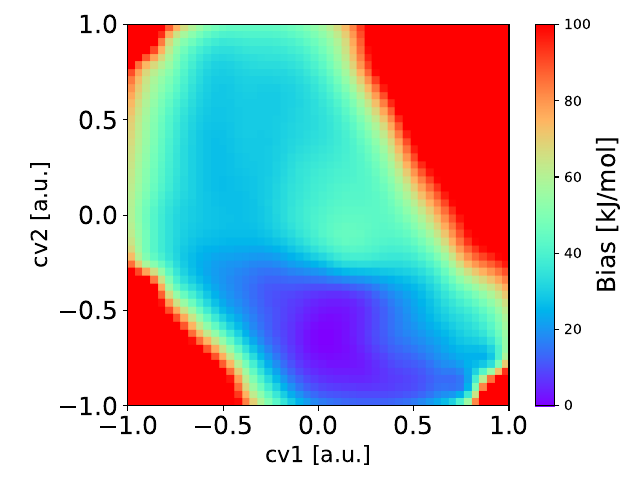

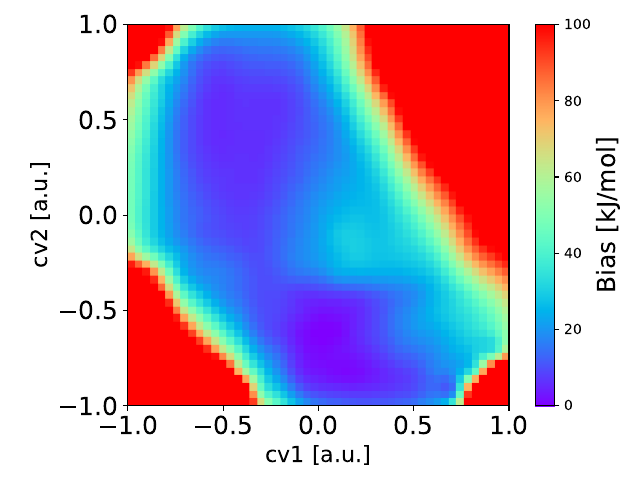

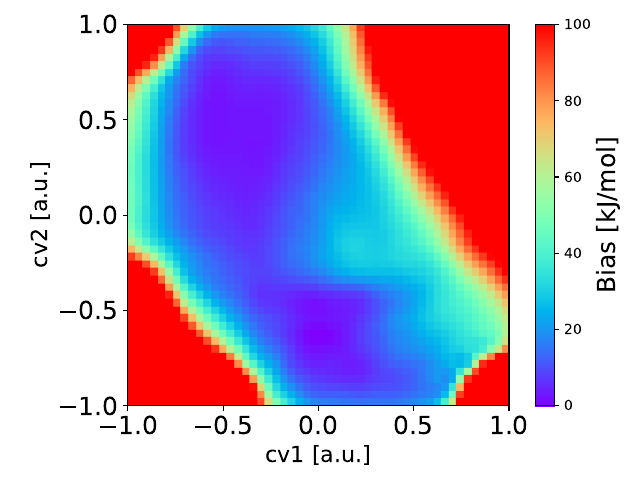

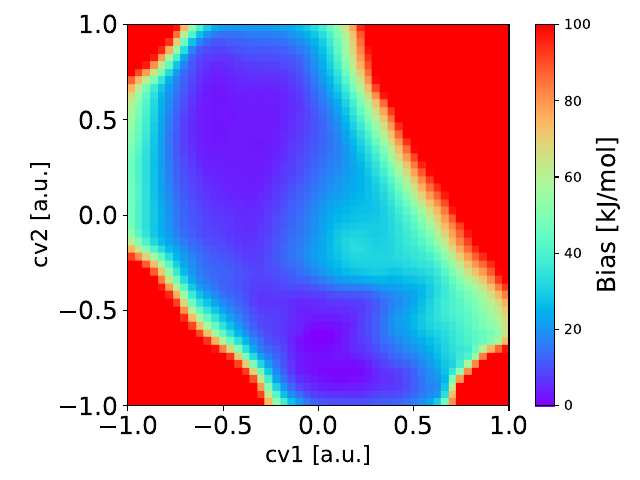

In [13]:
display(  *[ convert_from_path(folder/"cv_2"/f"FES_bias_{i}_inverted_rbf.pdf"    ,dpi=100  )[0]  for i in range(4,8) ]   )

The 2 stable phases are now clearly visible, and the profile has more or less converged. Lets apply an affine transformation such that the red part is cut out

In [10]:

import jax.numpy as jnp
from IMLCV.implementations.CV import affine_2d


affine_trans = affine_2d(jnp.array([[-1.4, 0.2],
                                    [-0.1, 1.4], 
                                    [1.1, -0.55],
                             [0.2, -1.5]]),
                  jnp.array([[-1, -1],
                             [-1, 1],
                             [1, 1],
                             [1, -1]]),
                  )

scheme0.transform_CV( affine_trans ,chunk_size=200, plot=True  )


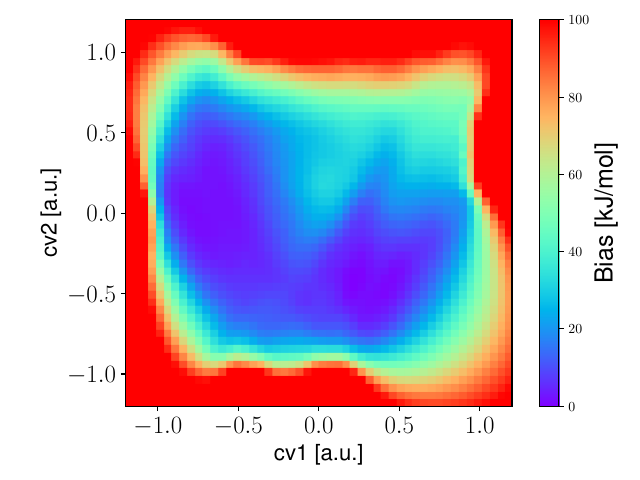

In [20]:
convert_from_path(folder/"cv_3"/"transformed_bias_inverted.pdf"    ,dpi=100  )[0] 

In [10]:
scheme0.inner_loop( rnds=3, n=8,steps=1000, init=0, plot=True, choice="rbf",fes_bias_rnds=4 ,samples_per_bin=300)


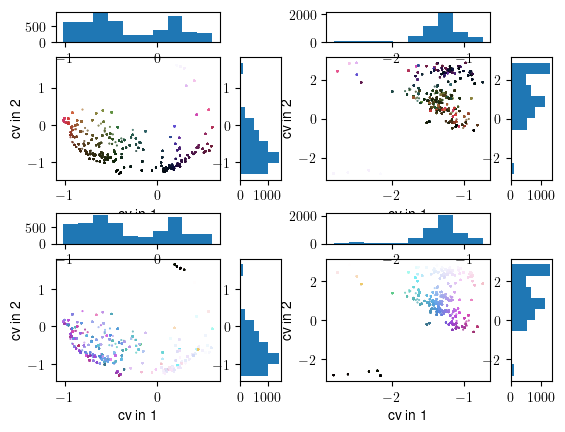

In [25]:
from IMLCV.base.CV import CollectiveVariable, CvMetric
from IMLCV.implementations.CV import dihedral
import numpy as np
from IMLCV.base.CVDiscovery import CVDiscovery

bd_cv0 = CollectiveVariable(
    f=(dihedral(numbers=[4, 6, 8, 14]) + dihedral(numbers=[6, 8, 14, 16])),
    metric=CvMetric(
        periodicities=[True, True],
        bounding_box=[[-np.pi, np.pi], [-np.pi, np.pi]],
    ),
)


umap_cv = CollectiveVariable(f=scheme0.md.bias.collective_variable.f*affine_trans,
                             metric=scheme0.md.bias.collective_variable.metric)


sp, nl, cv, sti = CVDiscovery.data_loader(
    scheme0.rounds, num=4, out=5e3, new_r_cut=scheme0.md.static_trajectory_info.r_cut, cv_round=2  )
CVDiscovery.plot_app(name=folder/"cv_3"/"comp_bd_trans.pdf",
                     sps=sp[0],   nl=nl[0],   old_cv=umap_cv, new_cv=bd_cv0, chunk_size=300)
